In [209]:
import pandas as pd
import geopandas as gpd
from fiona.crs import from_epsg
import shapely
import numpy as np
from sklearn.preprocessing import StandardScaler
import re

from matplotlib import pyplot as plt
%matplotlib inline

In [210]:
df = pd.read_csv("MTA_Turnstile_2016.csv")

In [211]:
df.drop(columns=["Unnamed: 0"],inplace=True)
df.rename(columns={'EXITS                                                               ':"EXITS"},inplace=True)
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/24/2016,03:00:00,REGULAR,5980509,2025806
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/24/2016,07:00:00,REGULAR,5980531,2025818
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/24/2016,11:00:00,REGULAR,5980613,2025912
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/24/2016,15:00:00,REGULAR,5980899,2025965
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/24/2016,19:00:00,REGULAR,5981382,2026001


In [212]:
df.dropna(subset=["DATE","TIME","STATION","ENTRIES","EXITS"],inplace=True)
df['MONTH'] = df['DATE'].map(lambda x: str(x).split('/')[0])
df = df[df['MONTH']=="12"]
df['HOUR'] = df['TIME'].map(lambda x: int(str(x).split(':')[0]))
df = df[df['HOUR'].isin([24,1,2,3])]
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,MONTH,HOUR
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/24/2016,03:00:00,REGULAR,5980509,2025806,12,3
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/25/2016,03:00:00,REGULAR,5981604,2026032,12,3
12,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2016,03:00:00,REGULAR,5982069,2026141,12,3
18,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/27/2016,03:00:00,REGULAR,5983110,2026450,12,3
24,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2016,03:00:00,REGULAR,5984684,2026977,12,3


In [213]:
df.drop(columns=["C/A","UNIT","SCP","LINENAME","DIVISION","DATE","TIME","DESC","MONTH","HOUR"],inplace=True)
df.head()

,STATION,ENTRIES,EXITS
0,59 ST,5980509,2025806
6,59 ST,5981604,2026032
12,59 ST,5982069,2026141
18,59 ST,5983110,2026450
24,59 ST,5984684,2026977


In [214]:
df = df.groupby("STATION").mean()
for c in df.columns:
    df[c] = StandardScaler().fit_transform(np.array(df[c]).reshape(-1, 1))
df.reset_index(inplace=True)
df.head()

,STATION,ENTRIES,EXITS
0,1 AV,1.572839,1.728345
1,103 ST-CORONA,-0.341962,-0.285950
2,104 ST,7.461919,7.740186
3,110 ST,-0.379176,-0.318298
4,111 ST,-0.355113,-0.322622


In [215]:
df2 = pd.read_csv("MTA_Stations_2010.csv",usecols=["NAME","the_geom"])
df2.rename(columns={'the_geom':'geometry'},inplace=True)
df2.head()

,NAME,geometry
0,Astor Pl,POINT (-73.99106999861966 40.73005400028978)
1,Canal St,POINT (-74.00019299927328 40.71880300107709)
2,50th St,POINT (-73.98384899986625 40.76172799961419)
3,Bergen St,POINT (-73.97499915116808 40.68086213682956)
4,Pennsylvania Ave,POINT (-73.89488591154061 40.66471445143568)


In [216]:
def map_names_df(x):
    x = x.lower()
    x = re.sub(r'[ ]*-[a-z ]*',"",x)
    x = re.sub(r'/[a-z ]*'," st",x)
    x = re.sub(r'street$',"st",x)    
    x = re.sub(r'rd st|th st|st st|nd st'," st",x)
    x = re.sub(r'rd av|th av|st av|nd av'," av",x)
    x = re.sub(r'rd dr|th dr|st dr|nd dr'," dr",x)    
    x = re.sub(r' st [a-z ]*'," st",x)
    x = re.sub(r'4av9 st',"4 av9 st",x)
    x = re.sub(r'^5 ave$',"5 av",x)
    x = re.sub(r'^5 av st53 st$',"5 av 53 st",x)
    x = re.sub(r'^5 av st59 st$',"5 av 59 st",x)
    x = re.sub(r'^lexington av st53$',"lexington av 53 st",x)
    x = re.sub(r'^lexington av st63$',"lexington av 63 st",x)
    x = re.sub(r'^174175 sts$',"174 175 sts",x)
    x = re.sub(r'(sq)([0-9]+)' , r'sq \2',x)
    x = re.sub(r'^182183 sts$',"182 183 sts",x)
    x = re.sub(r'^v.cortlandt pk$',"van cortlandt park 242 st",x)
    x = re.sub(r'([a-z]+)([0-9]+) st' , r'\1 \2 st',x)
    x = re.sub(r'^marble hill225$' , "marble hill 225 st",x)
    return x
    
def map_names_df2(x):
    x = x.lower()
    x = re.sub(r'[ ]*-[a-z ]*',"",x) 
    x = re.sub(r'street$',"st",x)
    x = re.sub(r'rd st|th st|st st|nd st'," st",x)
    x = re.sub(r'rd av|th av|st av|nd av'," av",x)
    x = re.sub(r'rd dr|th dr|st dr|nd dr'," dr",x)
    x = re.sub(r' ave'," av",x)
    x = re.sub(r"47th50 sts",'4750 sts rock',x)
    x = re.sub(r'^174th175 sts$',"174 175 sts",x)
    x = re.sub(r'(sq)([0-9]+)' , r'sq \2',x)
    x = re.sub(r'^182nd183 sts$',"182 183 sts",x)
    x = re.sub(r'([a-z]+)([0-9]+) st' , r'\1 \2 st',x)
    return x

In [195]:
re.sub(r'[ ]*-[a-z ]*',"","103 ST - CORONA".lower())

'103 st'

In [196]:
re.sub(r'(sq)([0-9]+)' , r'sq \2',"court sq23 st")

'court sq 23 st'

In [217]:
df["STATION"] = df["STATION"].map(map_names_df)
df2["NAME"] = df2["NAME"].map(map_names_df2)

In [218]:
df3 = df.merge(df2,left_on="STATION",right_on="NAME")
df3.dropna(inplace=True)
df3.head()

,STATION,ENTRIES,EXITS,NAME,geometry
0,1 av,1.572839,1.728345,1 av,POINT (-73.98168087489128 40.73097497580066)
1,103 st,-0.341962,-0.285950,103 st,POINT (-73.96837899960818 40.799446000334825)
2,103 st,-0.341962,-0.285950,103 st,POINT (-73.96137008267617 40.796060739904526)
3,103 st,-0.341962,-0.285950,103 st,POINT (-73.86269999830412 40.749865000555545)
4,103 st,-0.341962,-0.285950,103 st,POINT (-73.94747800152219 40.79060000008452)


In [219]:
df3.shape

(288, 5)

In [221]:
def get_longitude(x):
    return float(str(x).split(" ")[1][1:])

def get_latitude(x):
    return float(str(x).split(" ")[2][:-1])
    
df3['Latitude'] = df3['geometry'].map(get_latitude)
df3['Longitude'] = df3['geometry'].map(get_longitude)
df3.head()

,STATION,ENTRIES,EXITS,NAME,geometry,Latitude,Longitude
0,1 av,1.572839,1.728345,1 av,POINT (-73.98168087489128 40.73097497580066),40.730975,-73.981681
1,103 st,-0.341962,-0.285950,103 st,POINT (-73.96837899960818 40.799446000334825),40.799446,-73.968379
2,103 st,-0.341962,-0.285950,103 st,POINT (-73.96137008267617 40.796060739904526),40.796061,-73.961370
3,103 st,-0.341962,-0.285950,103 st,POINT (-73.86269999830412 40.749865000555545),40.749865,-73.862700
4,103 st,-0.341962,-0.285950,103 st,POINT (-73.94747800152219 40.79060000008452),40.790600,-73.947478


In [222]:
df3.drop(columns=["NAME","geometry"],inplace=True)
df3['lonlat'] = list(zip(df3.Longitude,df3.Latitude))
df3['geometry'] = df3[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

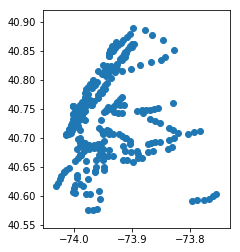

In [227]:
df3 = gpd.GeoDataFrame(df3)
df3.crs = from_epsg(4326)
df3.plot()

In [226]:
df3.drop(columns=["Latitude","Longitude","lonlat"],inplace=True)
df3.head()

,STATION,ENTRIES,EXITS,geometry
0,1 av,1.572839,1.728345,POINT (-73.98168087489128 40.73097497580066)
1,103 st,-0.341962,-0.285950,POINT (-73.96837899960818 40.79944600033483)
2,103 st,-0.341962,-0.285950,POINT (-73.96137008267617 40.79606073990453)
3,103 st,-0.341962,-0.285950,POINT (-73.86269999830412 40.74986500055554)
4,103 st,-0.341962,-0.285950,POINT (-73.94747800152219 40.79060000008452)


In [228]:
df3.to_file('MTA_Subway_Turnstile.shp', driver='ESRI Shapefile')

In [229]:
df3.to_csv('MTA_Subway_Turnstile.csv')